# Introduction

An unfortunately popular strategy for validating machine-learning models is to do a "scaffold split" of the data. The idea is behind the scaffold split is to identify chemical series/scaffolds in the data set and to move all molecules sharing one or more scaffolds to the test set. The intent here is to see how well a model performs on regions of chemical space which are different from those it was trained on. Scaffold splitting is one of a variety of validation methods proposed to provide a more "realistic" assessment of model performance than random (or bootstrap) splits do. This seems, in principle, like a great idea, particularly for models intended for lead-finding or lead-optimization, where one typically has data for a number of scaffolds which, hopefully, are active (or inactive) for similar reasons. Scaffold splitting, with good scaffold definitions, can also be quite useful in identify systematic problems in global models, like those used for ADME or safety endpoints.

The problem with doing a realistic scaffold split is that the definition of "scaffold" is specific to the particular data set (or project). A 2020 paper by Franziska Kruger and a couple of former colleagues at Novartis looked at the challenges here and published a tool which provides suggestions for what the chemical series might be in a particular data set: https://doi.org/10.1021/acs.jcim.0c00204. As an aside, a followup paper by Maximilian Beckers and the same two former colleagues applied this series-finding approach to an interesting historical analysis of med-chem project data: https://doi.org/10.1021/acs.jcim.2c00785

Given that Franziska's method is time-consuming and cannot be fully automated, the standard approach in the literature for doing a scaffold split is to use Bemis-Murcko scaffolds, commonly just called "Murcko scaffolds" (https://doi.org/10.1021/jm9602928). Briefly, the algorithm behind these scaffolds is to iteratively remove all degree-one atoms from a molecule, leaving the "central" set of rings and the atoms which connect them.

  > Aside: The RDKit implementation of "Murcko scaffolds" uses a slight variation of the original algorithm. Degree-one atoms with double bonds to atoms in the scaffold are also preserved. The logic behind this variation is that these atoms have a very strong impact on the shape and properties of the scaffold, so they should be part of the scaffold.

I think that doing a Murcko decomposition is a useful exercise for organizing a collection of molecules, particularly as part of either a scaffold network analysis or the type of scaffold-finding algorithm in Franziska's paper, but that it is poorly suited for use in either actually identifying the type of scaffold that medicinal chemists use to organize and reason about their data or for splitting data sets for validating machine learning models.

This was turning into a mega-post, so I'm going to split it into two. In this first one I will look of the number of "Murcko scaffolds" found in medicinal chemistry papers. This is done by looking at the compounds tested in ChEMBL33 Ki assays with between 20 and 100 unique compounds which came from a document with a DOI. I'd expect a typical med chem assay (these come from a single paper) to have compounds for a small number of chemical series along with a few reference compounds from the literature. And then in a second post, coming later, I will do an analysis of the similarity characteristics of leave-scaffold-out splits for a random selection of the Ki assays mentioned above using the modified spatial statistics we used in the SIMPD paper (https://doi.org/10.1186/s13321-023-00787-9).


## TL;DR

Looking across 7148 Ki assays, the median number of scaffolds per assay is 12. The median ratio of the number of scaffolds to the number of compounds in an assay is 0.4; the number of scaffolds is 40% of the number of compounds tested in an assay (= the compounds from a single med chem paper). This doesn't match my expectations at all, nor does it match what is actually observed in the five random papers I selected to spot check.

 > Final Note: The analysis in this post is focused on the type of data sets that commonly show up during lead finding or lead optimization. A Murcko scaffold analysis likely to be less wrong when partitioning datasets of diverse compounds that don't contain SAR series. Of course, in these cases a standard neighbor split works just as well.

In [23]:
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)
%load_ext sql

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Grabbing the data from ChEMBL

We pull all the compounds for each of the Ki assays in ChEMBL33 that are taken from a document with a DOI and a publication year. Then we keep the assays containing between 20 and 100 compounds - the idea of the upper limit here is to try and limit ourselves to the primary literature,

In [2]:
%sql postgresql://glandrum@stoat/chembl_33 \
  drop table if exists assay_counts
    
%sql postgresql://glandrum@stoat/chembl_33 \
  select assays.chembl_id,assay_id,count(distinct molregno) cnt into temporary table assay_counts \
      from assays join activities using (assay_id) \
                  join docs on (assays.doc_id = docs.doc_id) \
      where standard_type='Ki' and \
      assays.doc_id is not null and doi is not null and year is not null\
      group by (assays.chembl_id,assay_id);

aids = %sql postgresql://glandrum@stoat/chembl_33 \
    select * from assay_counts where cnt>20 and cnt<100;
len(aids)

Done.
53801 rows affected.
7148 rows affected.


7148

We now have a list with assay ChEMBL ID, assay ID (a primary key used in the database), and the number of compounds with data in the assay:

In [48]:
aids[:4]

[('CHEMBL857972', 157, 66),
 ('CHEMBL615643', 393, 24),
 ('CHEMBL615557', 535, 71),
 ('CHEMBL615558', 536, 30)]

Randomly reorder the assays:

In [49]:
import random
random.seed(0xC0FFEE)
random.shuffle(aids)
aids[:4]

[('CHEMBL1176478', 642589, 29),
 ('CHEMBL902340', 453190, 32),
 ('CHEMBL3877023', 1634231, 21),
 ('CHEMBL1959874', 807746, 36)]

# Looking at some of example results

In [61]:
aid = 'CHEMBL1803423'  # this was the first hit from ChEMBL 32
aid = aids[0][0]
structs = %sql postgresql://glandrum@stoat/chembl_33 \
  select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
        join assays using (assay_id) \
        join compound_structures using (molregno) \
        join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
    where assays.chembl_id=:aid \
      and standard_type='Ki'
len(structs)
    

29 rows affected.


29

Here are the compounds from that assay:

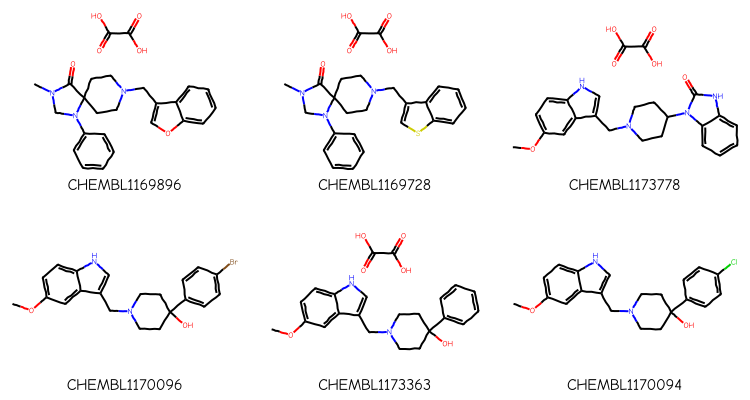

In [57]:
nms,smis = zip(*structs)
mols = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(mols[:6],legends=nms,subImgSize=(250,200))

Generate the Murcko scaffolds:

In [58]:
scaffs = []
for m in mols:
    scaff = Chem.MurckoDecompose(m)
    Chem.SanitizeMol(scaff)
    scaffs.append(scaff)
scaff_smis = [Chem.MolToSmiles(x) for x in scaffs]
len(set(scaff_smis))

12

There are twelve unique "scaffolds". Draw the first six of them:

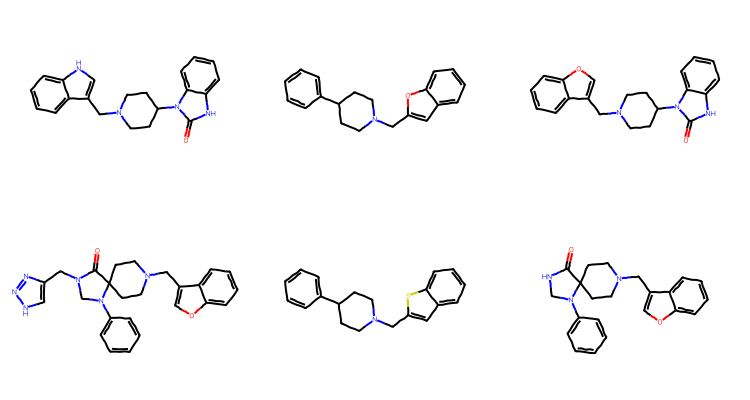

In [59]:
unique_scaffs = [Chem.MolFromSmiles(smi) for smi in set(scaff_smis)]
Draw.MolsToGridImage(unique_scaffs[:6],subImgSize=(250,200))

Some of these are quite similar to each other and others, like the first and last in the second row, are clearly structurally related - the last entry in the second row is a substructure of the first entry in that row.

Look at the compounds from another assay:

32 rows affected.


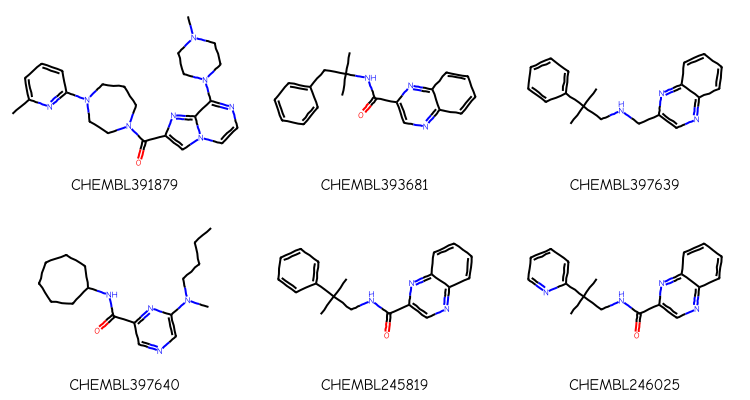

In [62]:
aid = aids[1][0]
structs = %sql postgresql://glandrum@stoat/chembl_33 \
  select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
        join assays using (assay_id) \
        join compound_structures using (molregno) \
        join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
    where assays.chembl_id=:aid \
      and standard_type='Ki'

nms,smis = zip(*structs)
mols = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(mols[:6],legends=nms,subImgSize=(250,200))


And generate the scaffolds:

20


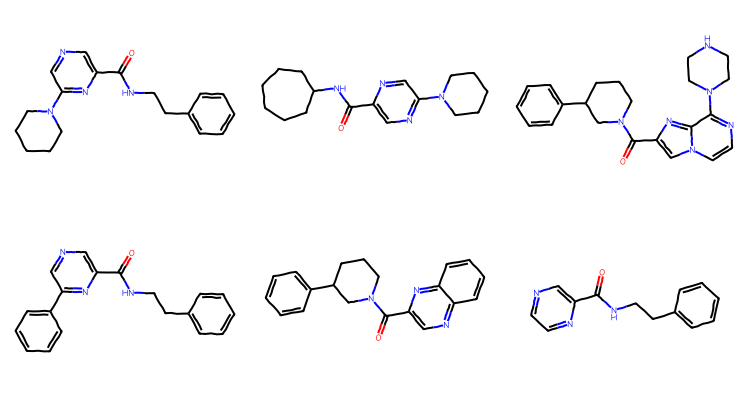

In [63]:
scaffs = []
for m in mols:
    scaff = Chem.MurckoDecompose(m)
    Chem.SanitizeMol(scaff)
    scaffs.append(scaff)
scaff_smis = [Chem.MolToSmiles(x) for x in scaffs]
print(len(set(scaff_smis)))
unique_scaffs = [Chem.MolFromSmiles(smi) for smi in set(scaff_smis)]
Draw.MolsToGridImage(unique_scaffs[:6],subImgSize=(250,200))

This time there are 20 scaffolds and some of them are QUITE similar to each other.

# Number of scaffolds per assay

Do the compound extraction and scaffold calculation for all of the assays:

In [69]:
%config SqlMagic.feedback = False

accum = []
for aid,_,_ in aids:
    structs = %sql postgresql://glandrum@stoat/chembl_33 \
      select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
        from activities \
            join assays using (assay_id) \
            join compound_structures using (molregno) \
            join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
        where assays.chembl_id=:aid \
          and standard_type='Ki'

    nms,smis = zip(*structs)
    mols = [Chem.MolFromSmiles(x) for x in smis]
    scaffs = set()
    for m in mols:
        scaff = Chem.MurckoDecompose(m)
        Chem.SanitizeMol(scaff)
        scaffs.add(Chem.MolToSmiles(scaff))
    accum.append((aid,len(mols),len(scaffs)))
    if not len(accum)%100:
        print(f'Done {len(accum)} of {len(aids)}')

Done 100 of 7148
Done 200 of 7148
Done 300 of 7148
Done 400 of 7148
Done 500 of 7148
Done 600 of 7148
Done 700 of 7148
Done 800 of 7148
Done 900 of 7148
Done 1000 of 7148
Done 1100 of 7148
Done 1200 of 7148
Done 1300 of 7148
Done 1400 of 7148
Done 1500 of 7148
Done 1600 of 7148
Done 1700 of 7148
Done 1800 of 7148
Done 1900 of 7148
Done 2000 of 7148
Done 2100 of 7148
Done 2200 of 7148
Done 2300 of 7148
Done 2400 of 7148
Done 2500 of 7148
Done 2600 of 7148
Done 2700 of 7148
Done 2800 of 7148
Done 2900 of 7148
Done 3000 of 7148
Done 3100 of 7148
Done 3200 of 7148
Done 3300 of 7148
Done 3400 of 7148
Done 3500 of 7148
Done 3600 of 7148
Done 3700 of 7148
Done 3800 of 7148
Done 3900 of 7148
Done 4000 of 7148
Done 4100 of 7148
Done 4200 of 7148
Done 4300 of 7148
Done 4400 of 7148
Done 4500 of 7148
Done 4600 of 7148
Done 4700 of 7148
Done 4800 of 7148
Done 4900 of 7148
Done 5000 of 7148
Done 5100 of 7148
Done 5200 of 7148
Done 5300 of 7148
Done 5400 of 7148
Done 5500 of 7148
Done 5600 of 7148
D

In [70]:
import pickle
with open('./results/murcko_scaffs.pkl','wb+') as outf:
    pickle.dump(accum,outf)

In [2]:
import pickle
with open('./results/murcko_scaffs.pkl','rb') as inf:
    accum = pickle.load(inf)

How many scaffolds are there in each assay?

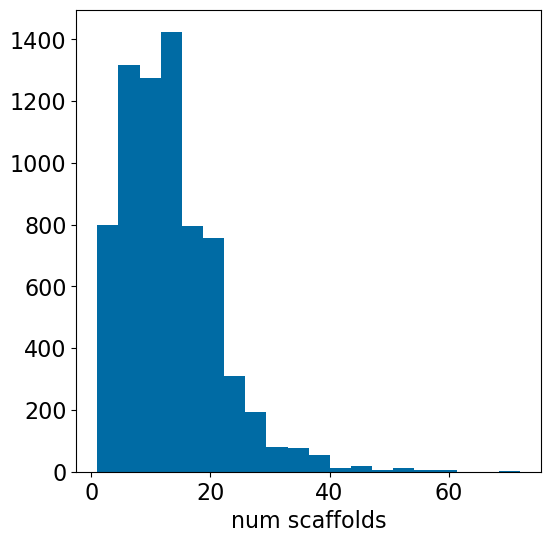

In [7]:
plt.figure(figsize=(6,6))
nscaffs = [x[2] for x in accum]
plt.hist(nscaffs,bins=20)
plt.xlabel('num scaffolds');

Stats of that:

In [10]:
print(f'mean: {np.mean(nscaffs):.1f}, median: {np.median(nscaffs):.1f}')

mean: 13.2, median: 12.0


That's a lot of scaffolds for each assay.

Since each assay contains a different number of compounds, it's interesting to look at the relationship between the number of compounds and the number of scaffolds:

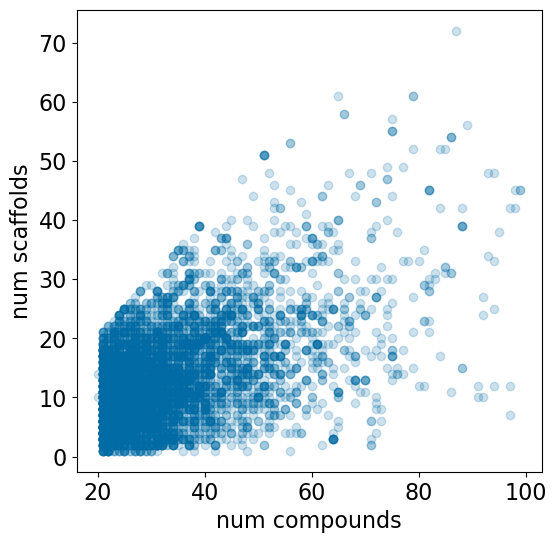

In [12]:
plt.figure(figsize=(6,6))
plt.scatter([x[1] for x in accum],[x[2] for x in accum],alpha=0.2)
plt.xlabel('num compounds')
plt.ylabel('num scaffolds');

We can summarize that with a histogram of the ratio of the number of scaffolds to the number of compounds:

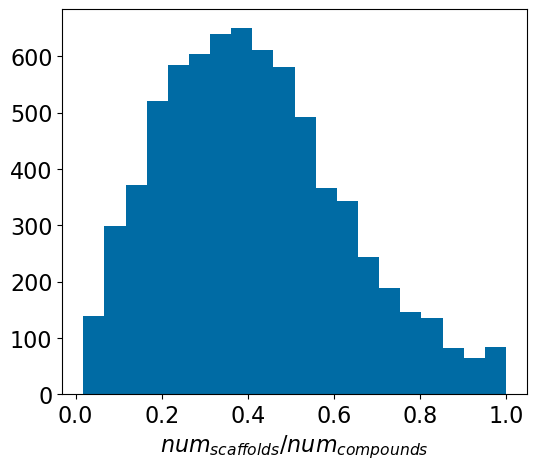

In [13]:
frac = [x[2]/x[1] for x in accum]
plt.figure(figsize=(6,5))
plt.hist(frac,bins=20)
plt.xlabel('$num_{scaffolds} / num_{compounds}$');

In [14]:
print(f'mean: {np.mean(frac):.1f}, median: {np.median(frac):.1f}')

mean: 0.4, median: 0.4


# Manually extracted scaffolds

To see what's going on in more detail, let's look at a few randomly selected assays/papers:

In [20]:
import random
acp = accum[:]
random.seed(0xf00d)
random.shuffle(acp)
for i,tpl in enumerate(acp[:5]):
    assay,nc,ns = tpl
    print(f'https://www.ebi.ac.uk/chembl/assay_report_card/{assay}/  {ns}   {nc}')

https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL4049094/  13   34
https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL859243/  10   39
https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL4710796/  16   23
https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3131699/  21   28
https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL4183750/  9   25


Get the compounds for each assay from the database:

In [21]:
%config SqlMagic.feedback = False

cmpd_accum = {}
for aid,_,_ in acp[:5]:
    structs = %sql postgresql://glandrum@stoat/chembl_33 \
      select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
        from activities \
            join assays using (assay_id) \
            join compound_structures using (molregno) \
            join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
        where assays.chembl_id=:aid \
          and standard_type='Ki'

    nms,smis = zip(*structs)
    mols = [Chem.MolFromSmiles(x) for x in smis]
    cmpd_accum[aid] = mols

In [24]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

I went through each of the papers and came up with a scaffold based for each on what the authors of the paper report as the scaffold. If there was no reported scaffold or something which was less-than-useful, I constructed on myself:

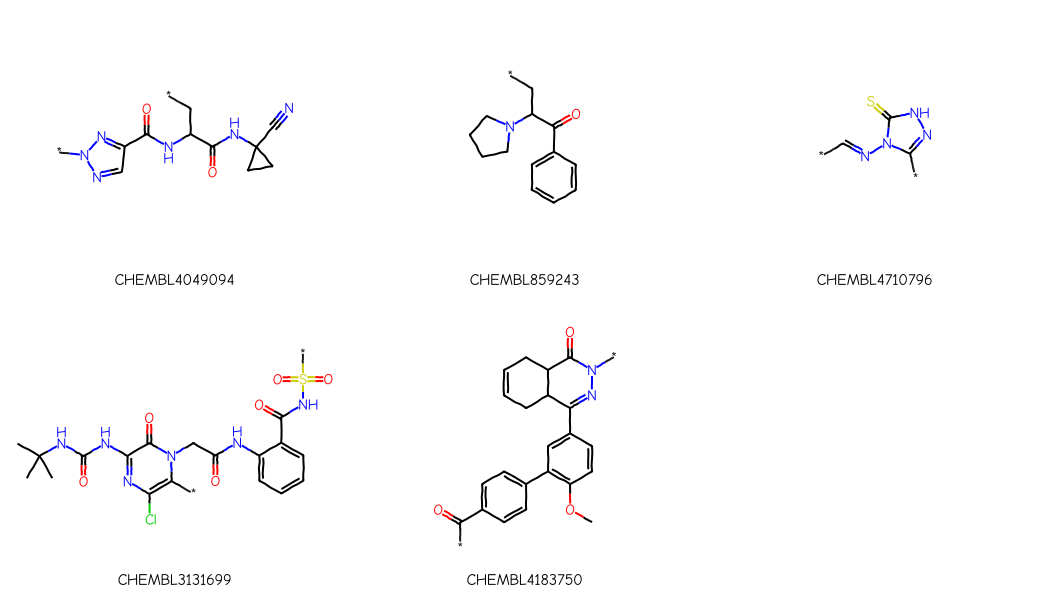

In [69]:
scaffolds_from_papers = {
    'CHEMBL4049094':'*n1ncc(n1)C(=O)NC(C*)C(=O)NC1(CC1)C#N',
    'CHEMBL859243':'*CC(N1CCCC1)C(=O)c1ccccc1',
    'CHEMBL4710796':'*c1n[nH]c(=S)n1N=C-*',
    'CHEMBL3131699':'CC(C)(C)NC(=O)Nc1nc(Cl)c(*)n(C1=O)CC(=O)Nc1ccccc1C(=O)NS(=O)(=O)*',
    'CHEMBL4183750':'*C(=O)c1ccc(cc1)c1c(OC)ccc(c1)C1=NN(*)C(=O)C2C1CC=CC2'
}
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries = True
for k in scaffolds_from_papers:
    scaffolds_from_papers[k] = Chem.AdjustQueryProperties(Chem.MolFromSmiles(scaffolds_from_papers[k]),ps)
    
Draw.MolsToGridImage(scaffolds_from_papers.values(),
                     legends=list(scaffolds_from_papers.keys()),
                     subImgSize=(350,300))

Confirm that these single scaffolds actually cover a reasonable number of the compounds in the paper:

In [70]:
for k in scaffolds_from_papers:
    nMatches = len([1 for x in cmpd_accum[k] if x.HasSubstructMatch(scaffolds_from_papers[k])])
    print(f'assay {k}:  num compounds={len(cmpd_accum[k])} num matching scaffold={nMatches}')

assay CHEMBL4049094:  num compounds=34 num matching scaffold=34
assay CHEMBL859243:  num compounds=39 num matching scaffold=31
assay CHEMBL4710796:  num compounds=23 num matching scaffold=22
assay CHEMBL3131699:  num compounds=28 num matching scaffold=22
assay CHEMBL4183750:  num compounds=25 num matching scaffold=21


Notice that in each case these individual scaffolds cover most of the compounds in the assay. This is a large contrast to the results from the Murcko decomposition, where even the most populous scaffolds typically cover less than half the compounds in the assay (see below).

And, finally, let's just look at those scaffolds together with the most populated Murcko scaffolds from each paper:

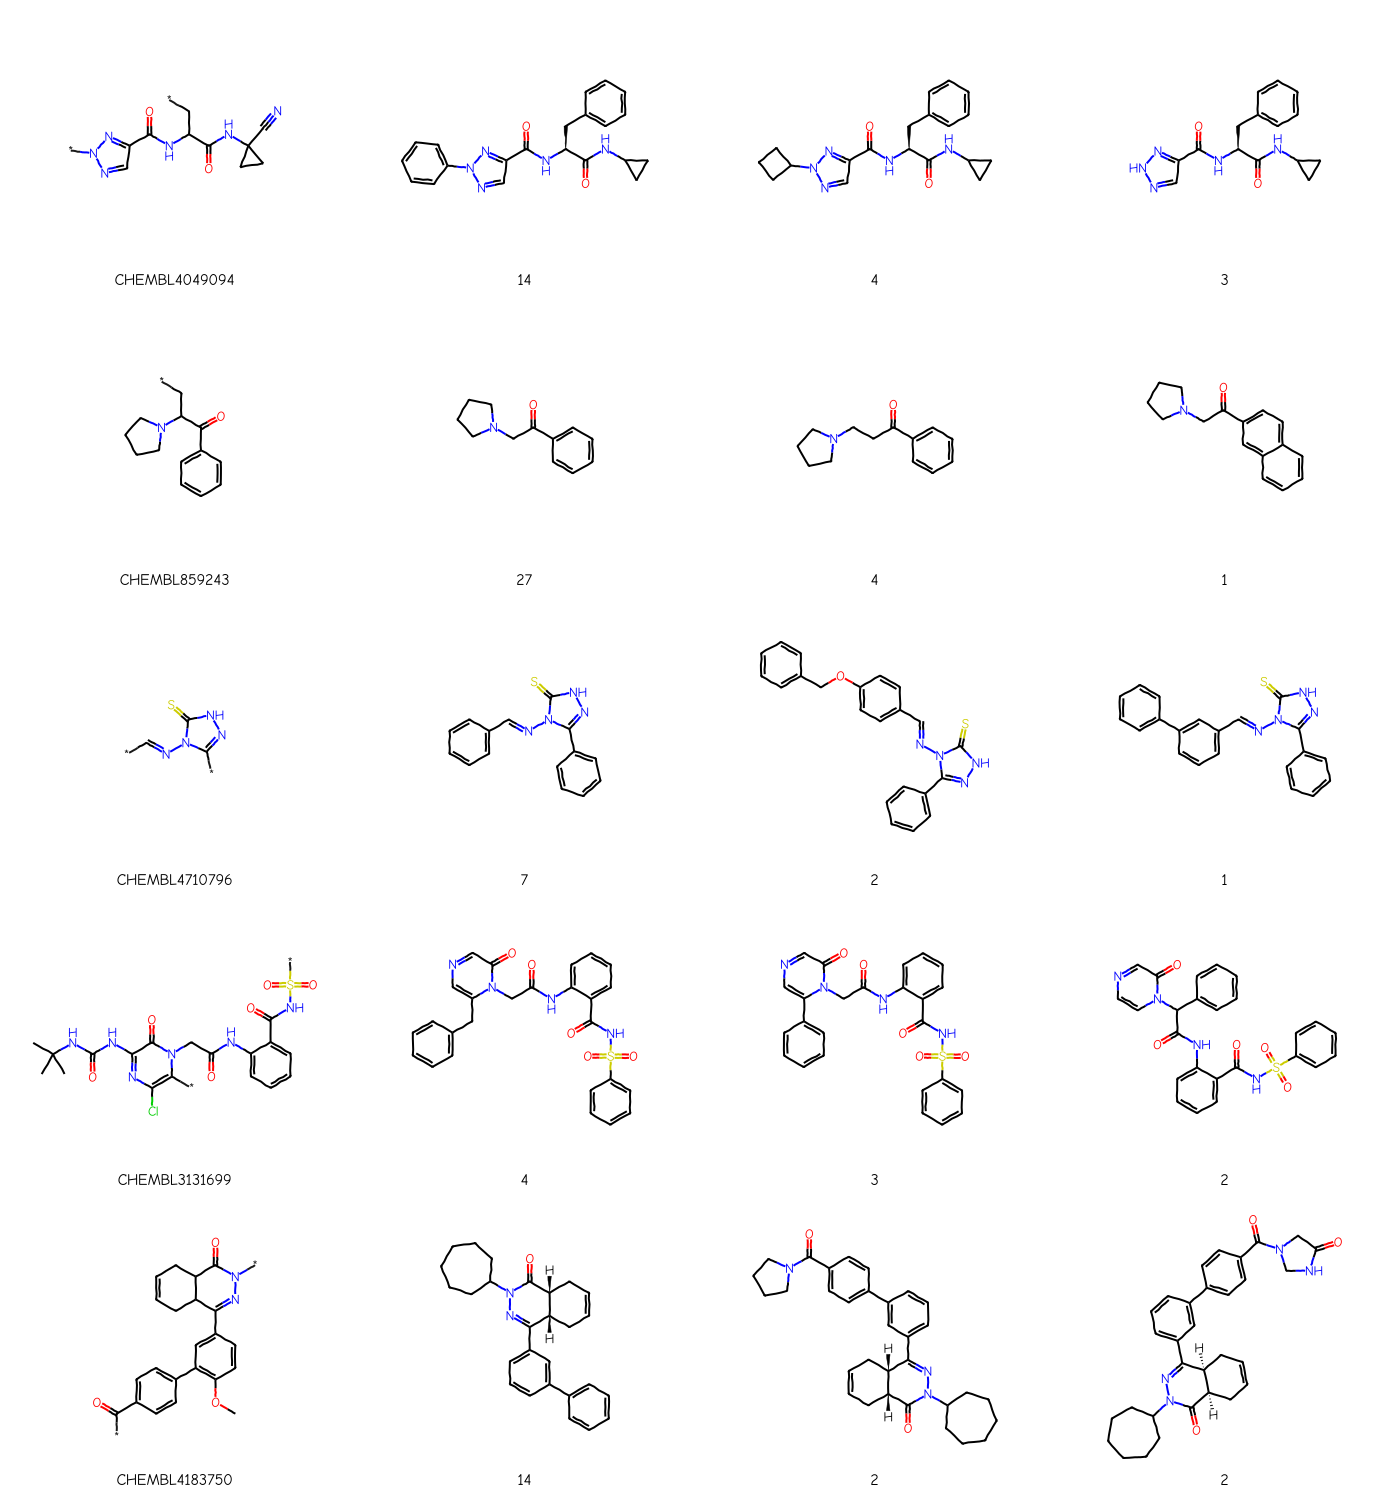

In [66]:
from collections import Counter
rows = []
labels = []
for k in scaffolds_from_papers:
    scaffs = {}
    counts = Counter()
    for m in cmpd_accum[k]:
        scaff = Chem.MurckoDecompose(m)
        Chem.SanitizeMol(scaff)
        smi = Chem.MolToSmiles(scaff)
        counts[smi] += 1
        scaffs[smi] = scaff
    row = [scaffolds_from_papers[k]]
    lrow = [k]
    top = counts.most_common(3)
    for smi,cnt in top:
        row.append(scaffs[smi])
        lrow.append(str(cnt))
    rows.extend(row)
    labels.extend(lrow)
Draw.MolsToGridImage(rows,
                     legends=labels,
                     molsPerRow=4,
                     subImgSize=(350,300))

Each row above has the hand-sketched scaffold in the first column and the three most common scaffolds along with their frequency in the remaining columns.

You can see that, with the exception of the second row (assay CHEMBL859243), the scaffolds found by the Murcko decomposition do not track particularly well with the scaffold extracted from the paper.